# 1. About Project
Cookie Cats is a popular mobile puzzle game developed by Tactile Entertainment. 
In this project, I will analyze the results of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention

## 1.2 Data Description
The data is from 90.189 players that installed the while the A/B test was running. 
Variables:
- *userid:* player id
- *version: * whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- *sum_gamerounds: * the number of game rounds played by the player during the first week after installation
- *retention_1: * did the player come back and play 1 day after installing?
- *retention_7: * did the player come back and play 7 days after installing?

when a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

## 1.3 Import Packages

In [1]:
import itertools 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal, kstest, ks_2samp
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.width', 500)

# 2.1 DataUnderstanding

In [3]:
df = pd.read_csv("cookie_cats.csv")

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(90189, 5)
##################### Types #####################
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object
##################### Head #####################
   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True
##################### Tail #####################
        userid  version  sum_gamerounds  retention_1  retention_7
90184  9999441  gate_40              97         True        False
90185  9999479  gate_40              30        False        False
90186  9999710  gate_30              28         True        False
90187  9999768  gate_4

## 2.2 Analyzing Player Behavior

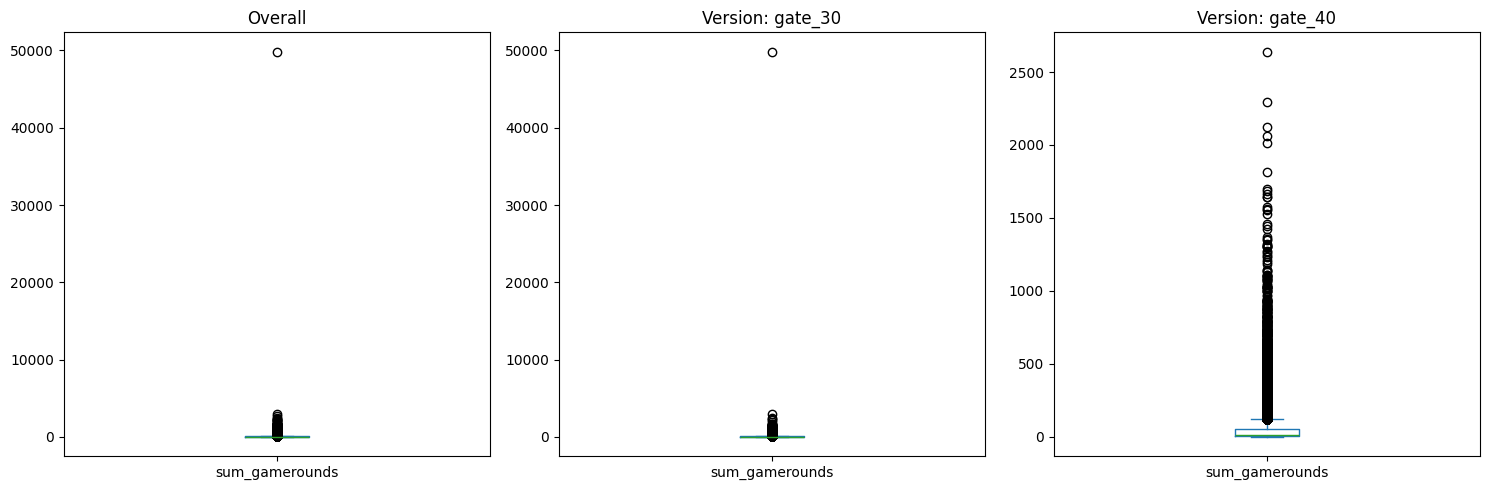

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and subplots

# Plotting the first boxplot
df['sum_gamerounds'].plot.box(ax=axes[0])
axes[0].set_title('Overall')

# Plotting the second boxplot
df.loc[df["version"] == "gate_30", 'sum_gamerounds'].plot.box(ax=axes[1])
axes[1].set_title('Version: gate_30')

# Plotting the third boxplot
df.loc[df["version"] == "gate_40", 'sum_gamerounds'].plot.box(ax=axes[2])
axes[2].set_title('Version: gate_40')

plt.tight_layout()
plt.show()

### Explore the distribution of game rounds

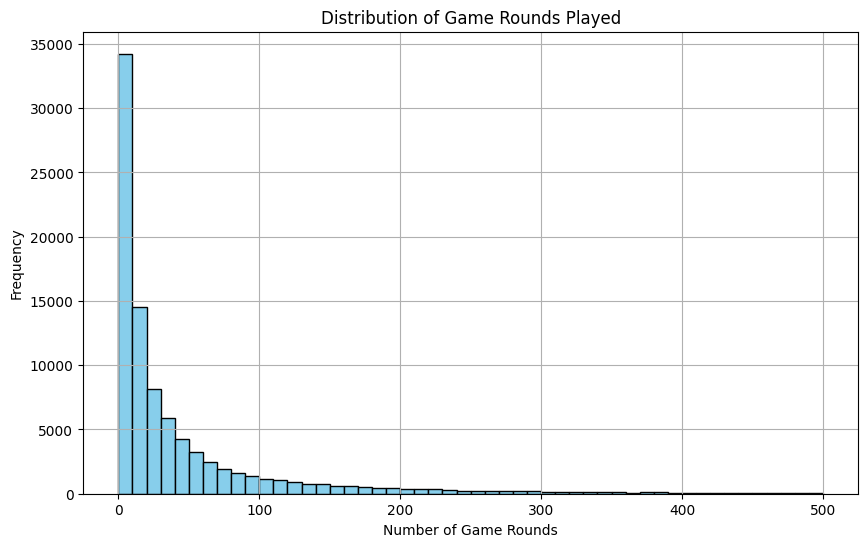

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(df['sum_gamerounds'], bins=50, range=(0, 500), color='skyblue', edgecolor='black')
plt.title('Distribution of Game Rounds Played')
plt.xlabel('Number of Game Rounds')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

* On the left side of the graph, tall bars indicate that a large number of players played fewer than 50 game rounds in their first week. 
* Moving to the right, the height of the bars decreases, showing a sharp decreases in the frequency of players as the number of game rounds increases. 
* The distribution has a long tail, indicating that a small number of players played more than 200 or 300 game rounds.

### Compare retention rates between different versions

In [7]:
retention_rates = df.groupby('version').agg(retention_1_rate=pd.NamedAgg(column='retention_1', aggfunc='mean'),
                                            retention_7_rate=pd.NamedAgg(column='retention_7', aggfunc='mean')
                                         ).reset_index()
retention_rates

,version,retention_1_rate,retention_7_rate
0,gate_30,0.44819,0.19020
1,gate_40,0.44228,0.18200


-  Retention rates for the gate_30 version are slightly higher than those for the gate_40 version on both day 1 and day 7.

### Analyze the relationship between game rounds played and retention

C:\Users\hbz\AppData\Local\Temp\ipykernel_23896\644437115.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='retention_1', y='sum_gamerounds', data=df, ax=axes[0], palette='Set1')
C:\Users\hbz\AppData\Local\Temp\ipykernel_23896\644437115.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='retention_7', y='sum_gamerounds', data=df, ax=axes[1], palette='Set1')


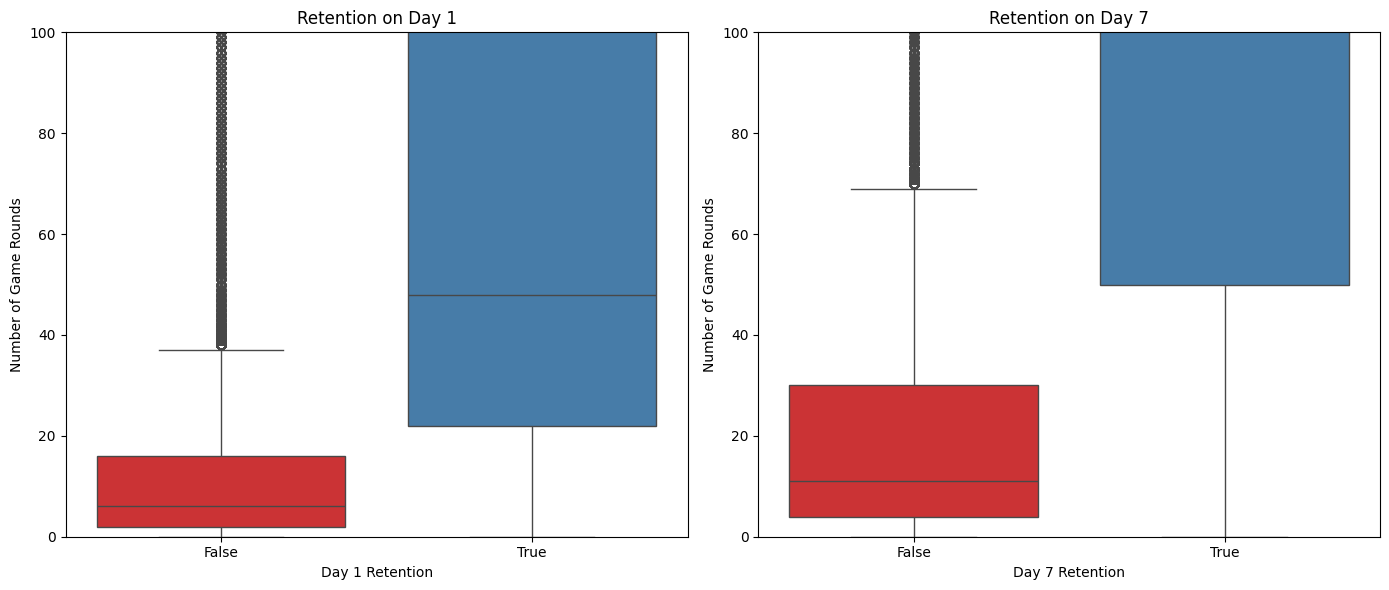

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for retention on day 1
sns.boxplot(x='retention_1', y='sum_gamerounds', data=df, ax=axes[0], palette='Set1')
axes[0].set_title('Retention on Day 1')
axes[0].set_xlabel('Day 1 Retention')
axes[0].set_ylabel('Number of Game Rounds')
axes[0].set_ylim(0, 100)

# Box plot for retention on day 7
sns.boxplot(x='retention_7', y='sum_gamerounds', data=df, ax=axes[1], palette='Set1')
axes[1].set_title('Retention on Day 7')
axes[1].set_xlabel('Day 7 Retention')
axes[1].set_ylabel('Number of Game Rounds')
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

* Day 1 Retention: Players who retained on day 1(True) tent to have played more game rounds than those who did not retain (False). This is indicated by the higher median and larger spread of the box for terained players.

* Day 7 Retention: Similarly, players who retained on day 7(True) tend to have played more game rounds than those who did not retain(False). The difference in medians and the spread of the boxes is more pronounced for day 7 retention compared to day 1 retention.

- Sum of the number of rounds player played based on versions:

In [13]:
df.groupby('version').agg({"sum_gamerounds": "count"})

,sum_gamerounds
version,
gate_30,44700
gate_40,45489


- Mean of the number of rounds player played based on versions

In [14]:
df.groupby("version").agg({"sum_gamerounds" : "mean"})

,sum_gamerounds
version,
gate_30,52.45626
gate_40,51.29878


# 3 Extreme Values

In [15]:
df_gate_40 = df[df["version"] == "gate_40"]
df_gate_30 = df[df["version"] == "gate_30"]

def outlier_thresholds(dataframe, variable):
    quartile3 = df[variable].quantile(0.01)
    quartile1 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile1 - quartile3
    upper_limit = quartile1 + interquantile_range * 1.5
    lower_limit = quartile3 - interquantile_range * 1.5
    return upper_limit, lower_limit

def replace_with_threshold(dataframe, variable):
    upper_limit, lower_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > upper_limit), variable] = round(upper_limit)
    dataframe.loc[(dataframe[variable] < lower_limit), variable] = round(lower_limit)
    
replace_with_threshold(df_gate_40, "sum_gamerounds")
replace_with_threshold(df_gate_30, "sum_gamerounds")

df_new = pd.concat([df_gate_40, df_gate_30], ignore_index=True)   

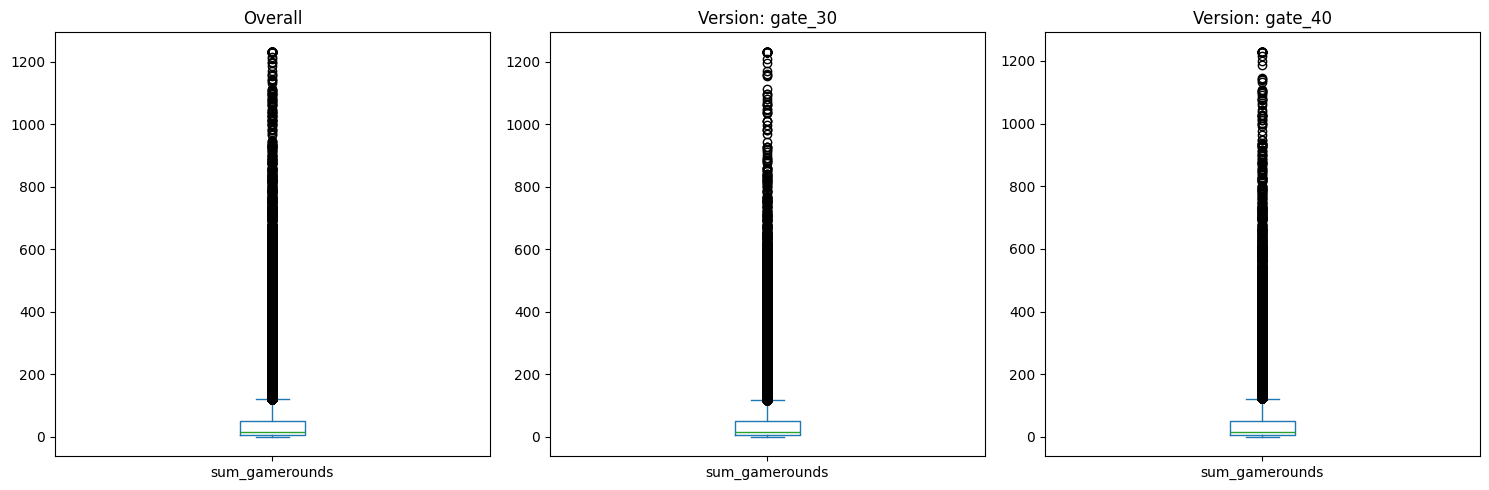

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create a figure and subplots

# Plotting the first boxplot
df_new['sum_gamerounds'].plot.box(ax=axes[0])
axes[0].set_title('Overall')

# Plotting the second boxplot
df_new.loc[df_new["version"] == "gate_30", 'sum_gamerounds'].plot.box(ax=axes[1])
axes[1].set_title('Version: gate_30')

# Plotting the third boxplot
df_new.loc[df_new["version"] == "gate_40", 'sum_gamerounds'].plot.box(ax=axes[2])
axes[2].set_title('Version: gate_40')

plt.tight_layout()
plt.show()

# 4.1 A/B Test